In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import kruskal
from scipy import stats

In [84]:
data = pd.read_excel(r"C:\Users\John\Desktop\Case study and tasks.xlsx",index_col = 'Week', usecols = 'A:K')

**INITIAL DATA EXPLORATION AND DATA CLEANING**

In [85]:
data.head(10)

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9
Week,,,,,,,,,,
1,278.311490,4.048930,41.599122,76.860586,3.306652,17.480832,1.966124,66.547168,NaN,NaN
2,217.057702,3.044779,43.202310,91.151793,3.679933,37.503484,4.686061,82.966390,NaN,NaN
3,253.287799,3.159210,42.730285,60.154976,4.190961,25.186705,2.680526,65.331642,NaN,NaN
4,265.328814,3.900010,37.700943,87.193217,4.121617,19.027964,3.154189,73.440647,NaN,NaN
5,251.268841,4.503851,48.676045,79.477489,2.494535,25.466700,3.497675,78.233499,NaN,NaN
6,255.103114,4.001911,44.940127,95.304912,4.608854,36.541967,2.605209,62.808083,NaN,NaN
7,293.894442,4.207400,47.387186,90.635838,5.914207,19.199839,4.186904,73.342213,NaN,NaN
8,317.948757,5.017209,53.212308,98.268058,5.948611,23.757360,3.159357,60.910908,NaN,NaN
9,203.089675,4.285299,48.694811,87.982734,5.910321,41.709567,2.450189,85.447366,NaN,NaN


First of all lets check the data types are parsed correctly

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 1 to 156
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       156 non-null    float64
 1   x1      156 non-null    float64
 2   x2      156 non-null    float64
 3   x3      156 non-null    float64
 4   x4      156 non-null    float64
 5   x5      156 non-null    float64
 6   x6      156 non-null    float64
 7   x7      156 non-null    float64
 8   x8      6 non-null      float64
 9   x9      6 non-null      float64
dtypes: float64(10)
memory usage: 13.4 KB


According to the data mapping , the variables are loaded correctly as floats.

Apparently x8 and x9 only have 6 non-null variables. They most likely will be dropped due to the low information they provide. However they will be examined first.

Both x8 and x9 are the amount spend of TV ads , so we will assume that if an entry is null - no amount was spent on ads. Therefore the nulls will be replaced by zeroes.

In [87]:
data.fillna(0,inplace = True)

Now we will check the summary statistics of the dataset to understand the distribution of the variables

In [88]:
data.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,240.450619,3.801749,39.828012,80.050145,4.237722,30.602409,3.143404,70.273887,4.858974,3.814103
std,52.674908,0.519048,9.772319,9.727006,0.799152,10.086287,0.782763,13.602483,27.196643,21.880262
min,88.312166,2.483894,17.173575,51.626388,2.148033,5.510653,0.789581,33.797620,0.000000,0.000000
25%,205.114804,3.437313,34.120493,73.530726,3.744285,23.728610,2.552200,61.504579,0.000000,0.000000
50%,242.784360,3.850209,40.204720,79.685159,4.175268,31.073937,3.095594,68.706459,0.000000,0.000000
75%,274.662462,4.110384,46.581087,87.029627,4.807396,36.645337,3.671068,80.549885,0.000000,0.000000
max,367.448861,5.131677,63.522353,98.621897,6.590597,70.140502,5.298888,96.286134,220.000000,205.000000


In all variables except x8 and x9 , the mean is very close to the median which means the data is centered and this suggests that there might be few - to no outliers. We will look into this later on.

Check for outliers

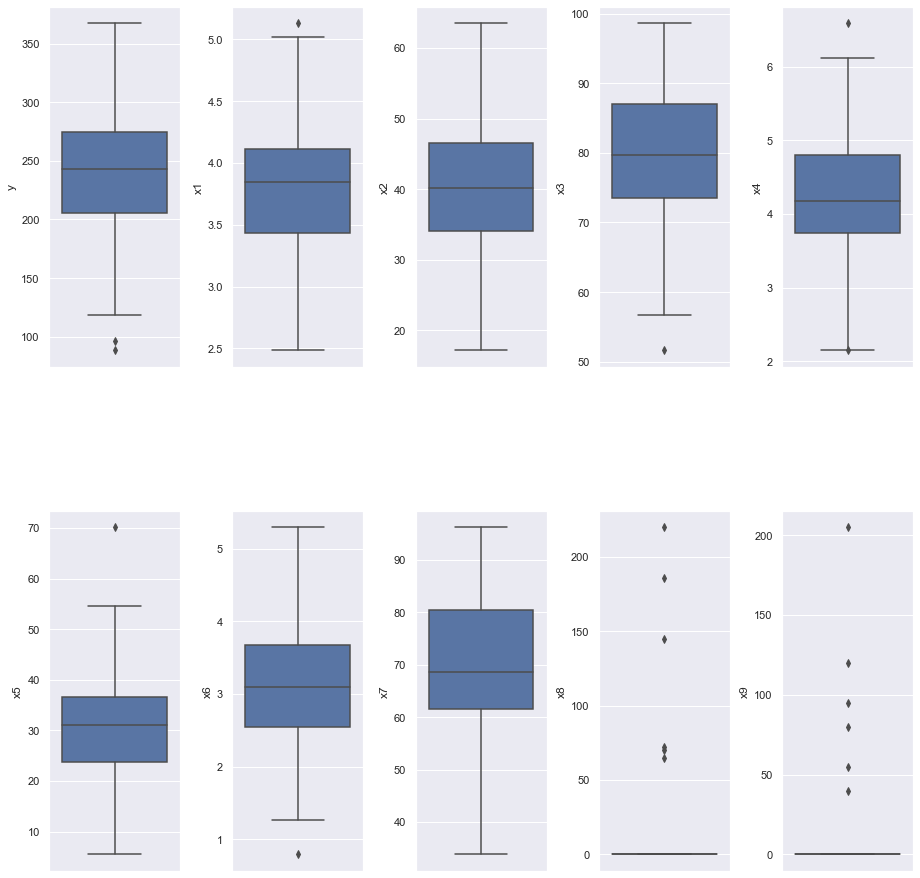

In [89]:
plt.subplots(nrows=2 , ncols=2 , figsize=(15,15))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

for i in range(len(data.columns)):
    
    plt.subplot(2,5,i+1)
    sns.boxplot(data = data[data.columns[i]] , y =data[data.columns[i]] )

From the above boxplots we can see that variables x1,x2,x3,,x4,x5 and x6 have a few outliers and they will be treated using the IQR method. 
Note that variables x8 and x9 appear to have only outliers which is expected since they only contained 6 entries and 150 nulls.

We will perform IQR to remove the outliers in the columns mentioned above. We wont remove them from x8 and x9 from now.

In [90]:
def replace_outliers(column_name):

 Q1 = data[column_name].quantile(0.25)
 Q3 = data[column_name].quantile(0.75)
 IQR = Q3 - Q1
 data[column_name] = np.where(data[column_name]>Q3+1.5*IQR,Q3+1.5*IQR,np.where(data[column_name]<Q1-1.5*IQR,Q1-1.5*IQR,data[column_name]))

In [91]:
columns_to_perform_IQR = [x for x in data.columns]
columns_to_perform_IQR.remove('x8')
columns_to_perform_IQR.remove('x9')

In [92]:
for column in columns_to_perform_IQR:
    replace_outliers(column)

**TASK 1 Data Exploration**

In [93]:
columns = [x for x in data.columns]

c:\Users\John\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\John\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\John\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

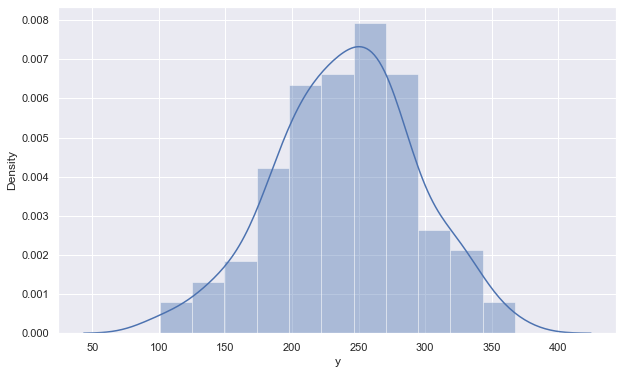

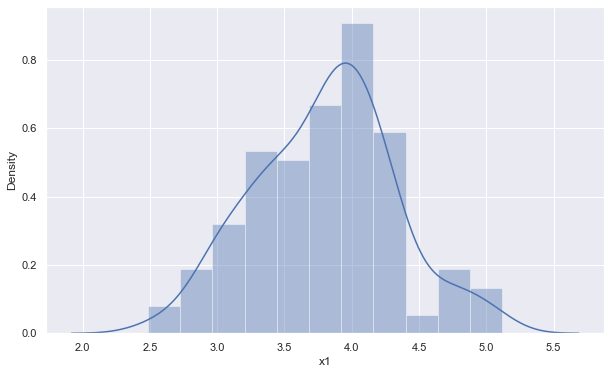

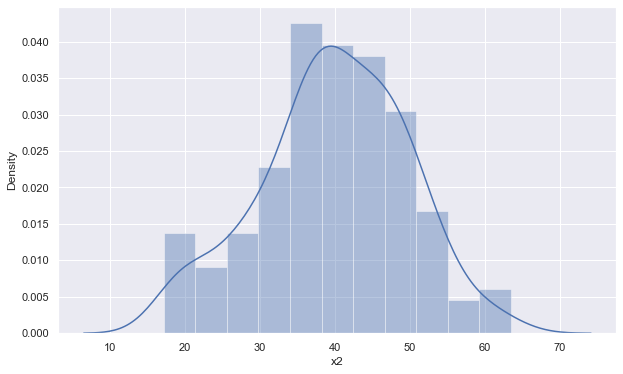

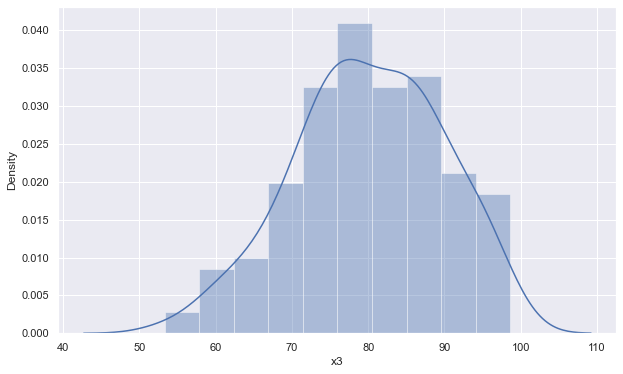

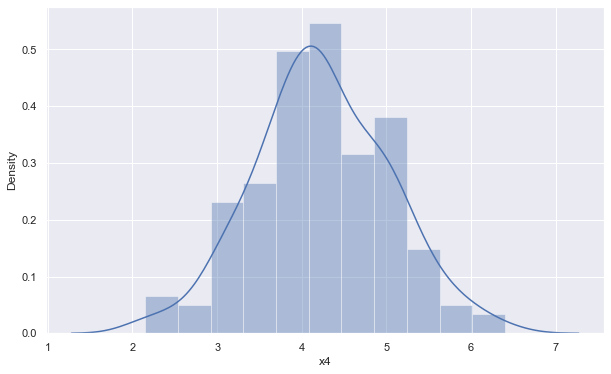

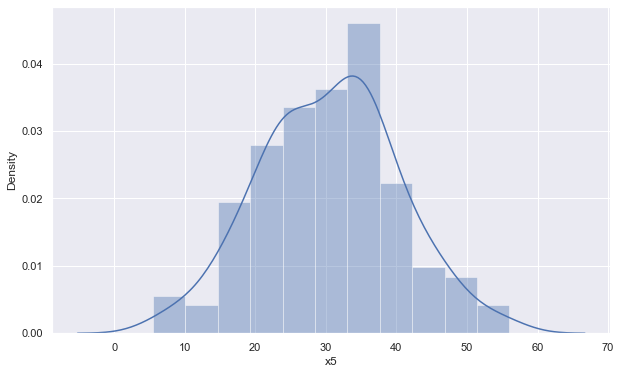

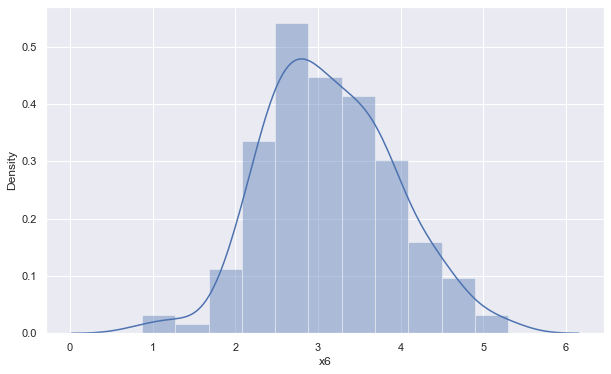

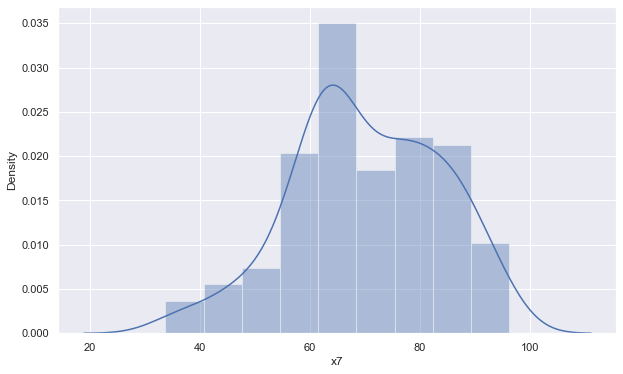

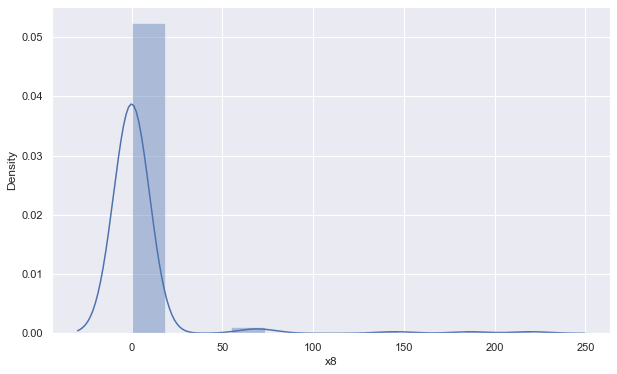

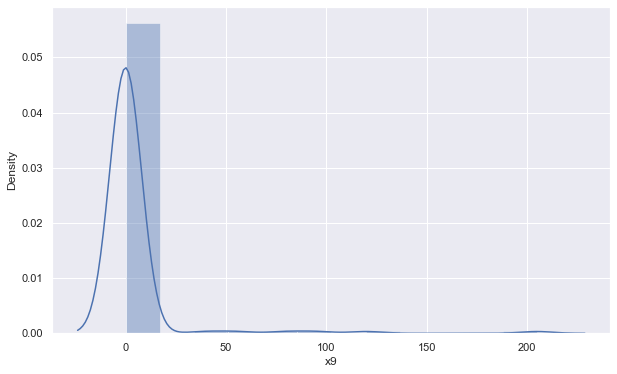

In [94]:
for i in columns:
    plt.figure(figsize=(10, 6))
    sns.distplot(data[i]);

The distribution of the variables is roughly symmetrical except from x8,x9 which is expected.

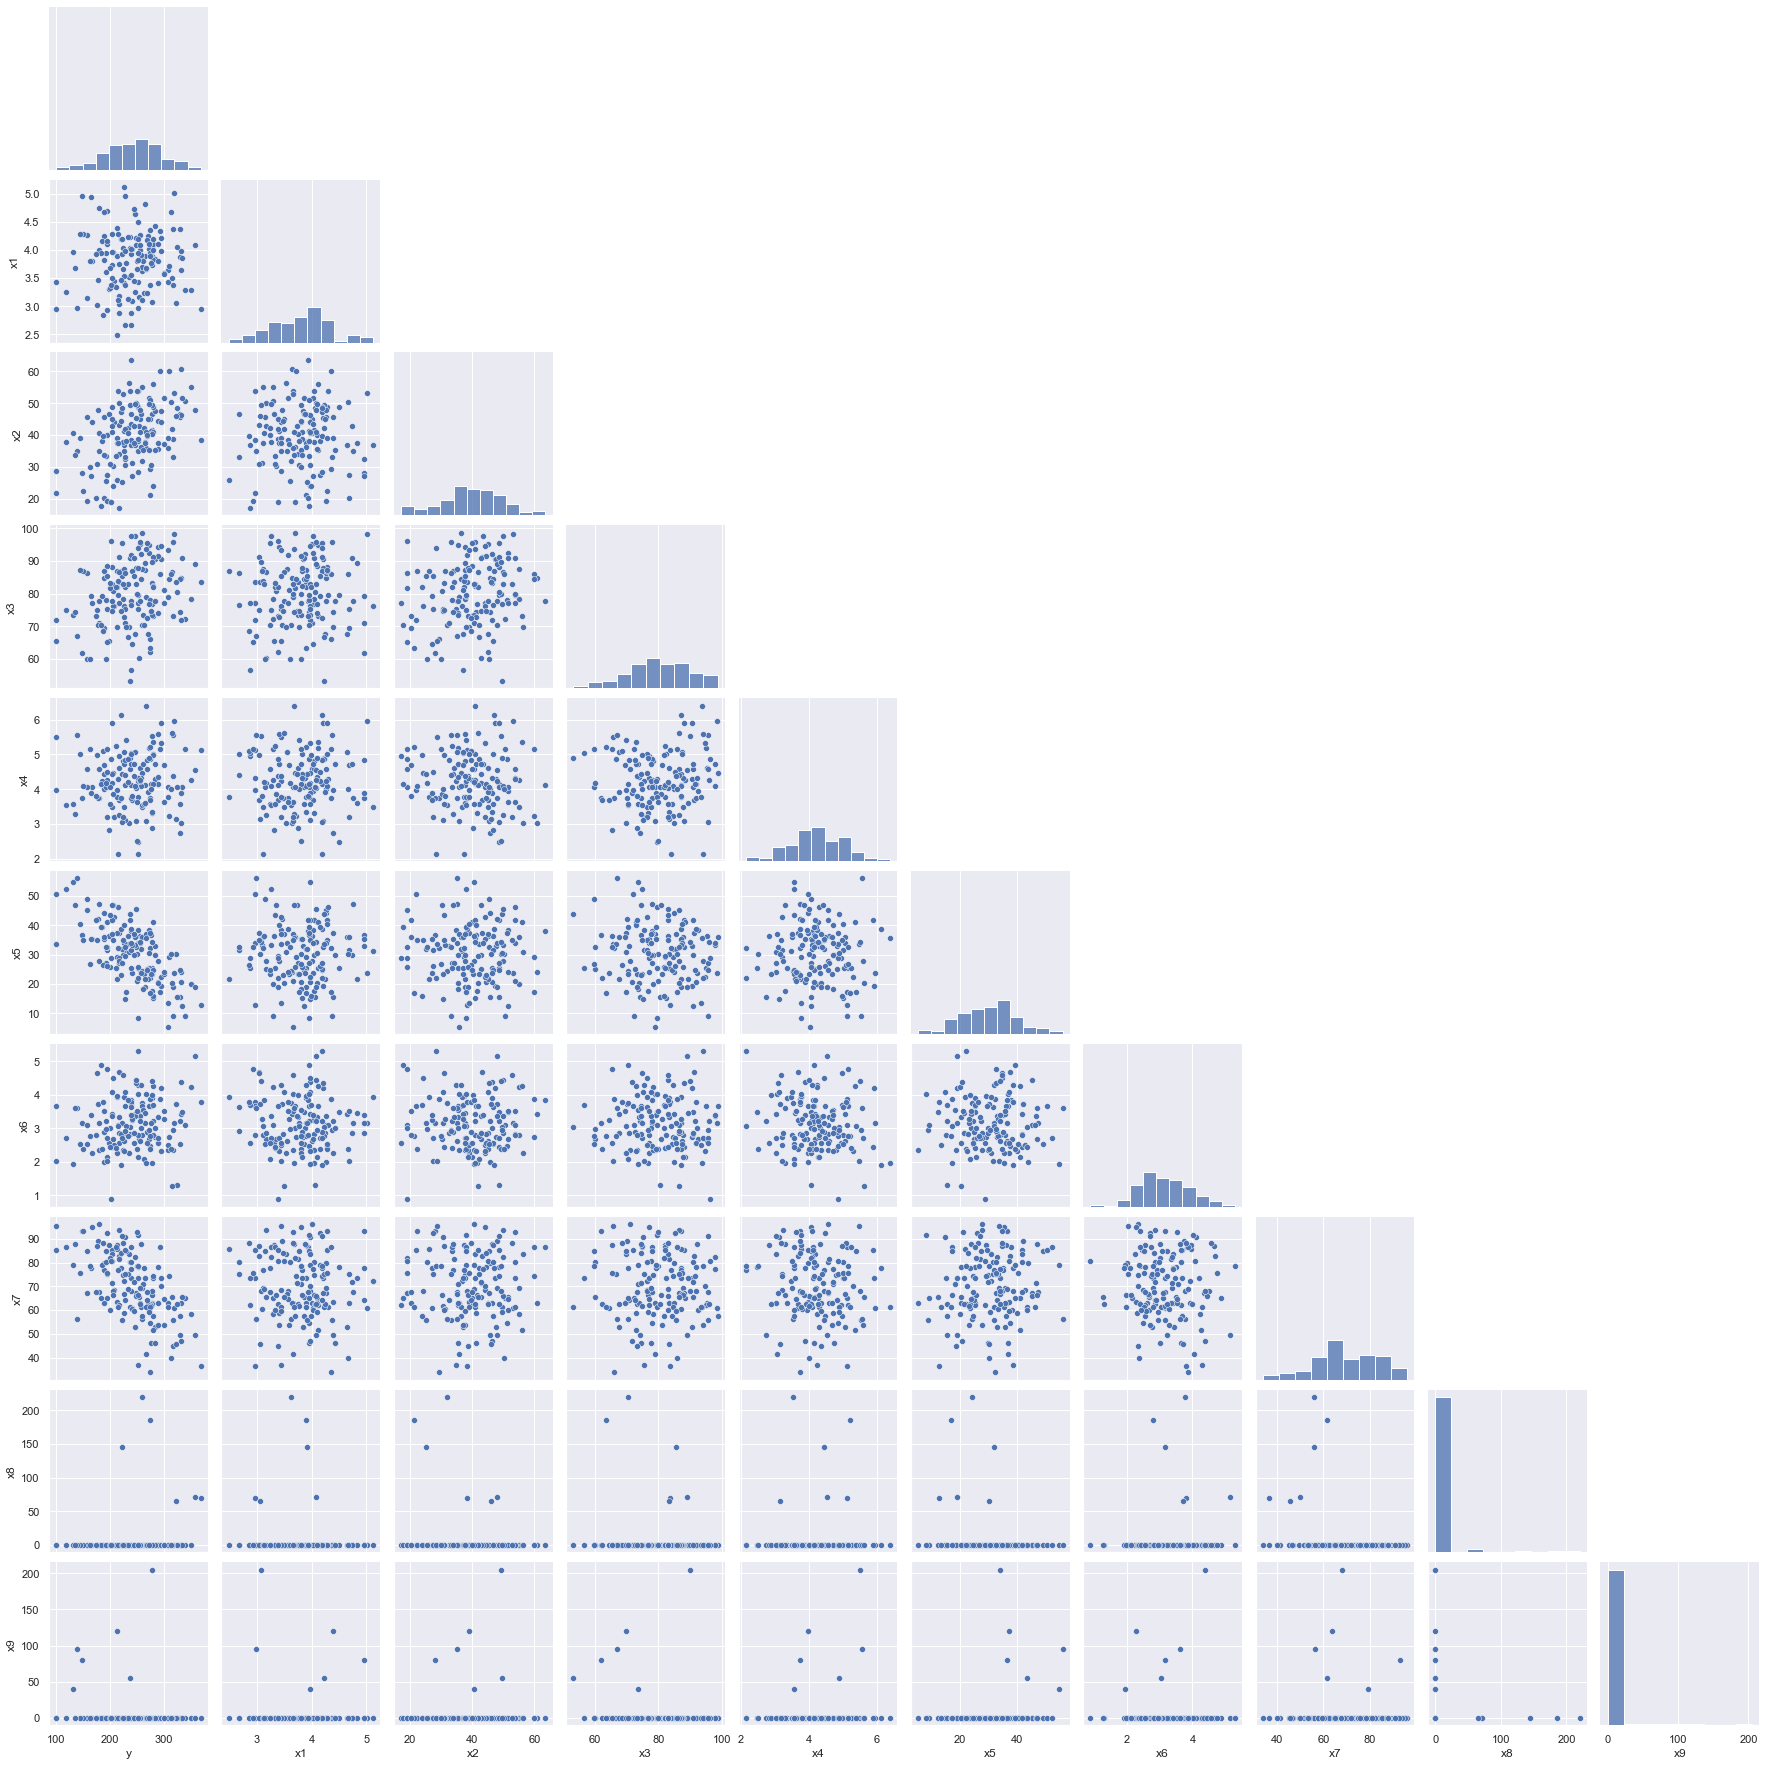

In [95]:
sns.pairplot(data,corner = True ,height = 2.5)

From the above scatterplots we can notice the below regarding the relationship of y (own product sales) and the independet variables: 
1. there is almost no linear relationship with x1 , the own products price meaning that sales are more invariant in price changes.
2. there is a strong positive linear relationship with x2 which is our own product's promos meanining that promos have a positive effect on sales.
3. there is a positive linear relationship with x3 which is our own distribution , meaning that our own product's presence in stores has a positive effect on sales.
4. there is almost no linear relationship with x4 , which means that the competitors 1 product price doesnt affect our sales much.
5. there is a strong negative linear relationship with x5 , meaning that the promos of competitor 1 have a negative effect on our sales
6. there seems to be a weak linear relationship with x6 
7. there is a strong negative linear relationship with x7
8. x8 and x9 do not seem to affect our sales this is mostly due to the very few data points they contain.

We will check the above hypothesis, but first let us check for multicolinearity using pairwise Pearson correlation

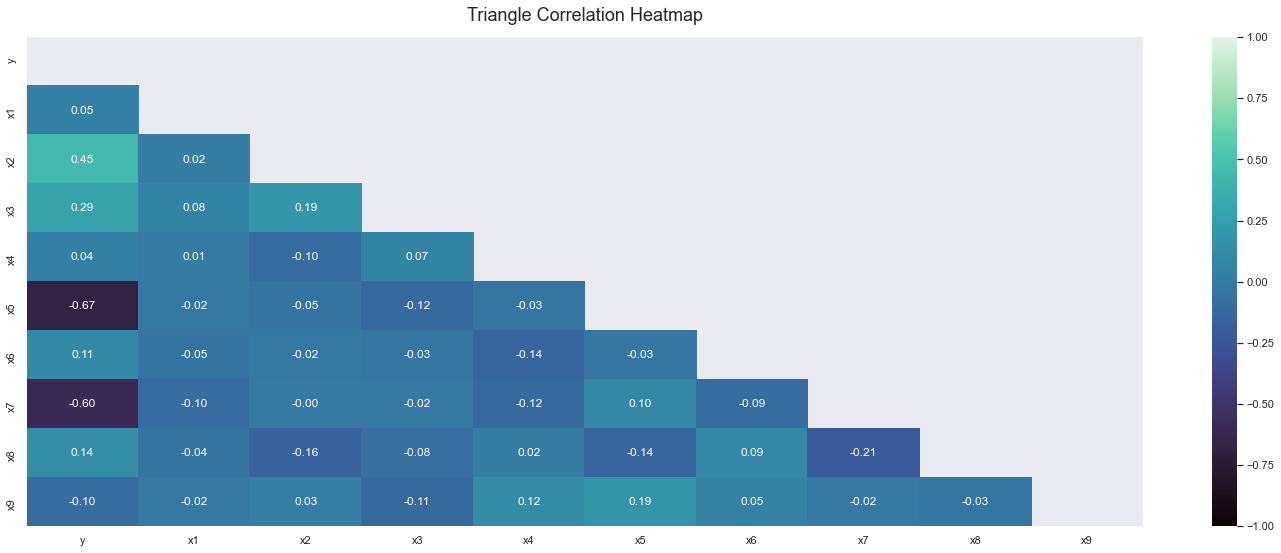

In [96]:
mask = np.triu(np.ones_like(data.corr(), dtype=bool))
sns.set(rc = {'figure.figsize':(25,9)})
heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='mako',fmt='.2f')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);


The independent features appear to be pairwise independent ( no correlation between xi is significant enough) so we can assume that there is no multicolinearity.

Since the data is time dependent we will explore for seasonality and trend patterns.To that end we add a new feature 'month' to the data.

In [97]:
data['week']=data.index
data['year']=((data['week']-1)//52)+1
data['week_number']=data.groupby('year').cumcount()+1
#data.drop('year',axis=1 , inplace =True)

In [98]:
month_1=np.arange(1,5).tolist()
month_2=np.arange(5,9).tolist()
month_3=np.arange(9,14).tolist()
month_4=np.arange(14,18).tolist()
month_5=np.arange(18,22).tolist()
month_6=np.arange(22,27).tolist()
month_7=np.arange(27,31).tolist()
month_8=np.arange(31,35).tolist()
month_9=np.arange(35,40).tolist()
month_10=np.arange(40,44).tolist()
month_11=np.arange(44,48).tolist()
month_12=np.arange(48,53).tolist()

In [99]:
data.loc[data['week_number'].isin(month_1), 'month'] = 1
data.loc[data['week_number'].isin(month_2), 'month'] = 2
data.loc[data['week_number'].isin(month_3), 'month'] = 3
data.loc[data['week_number'].isin(month_4), 'month'] = 4
data.loc[data['week_number'].isin(month_5), 'month'] = 5
data.loc[data['week_number'].isin(month_6), 'month'] = 6
data.loc[data['week_number'].isin(month_7), 'month'] = 7
data.loc[data['week_number'].isin(month_8), 'month'] = 8
data.loc[data['week_number'].isin(month_9), 'month'] = 9
data.loc[data['week_number'].isin(month_10), 'month'] = 10
data.loc[data['week_number'].isin(month_11), 'month'] = 11
data.loc[data['week_number'].isin(month_12), 'month'] = 12

In [100]:
data['month'] = data['month'].astype(int)

What is our promotional activity compared to Competitor 1?

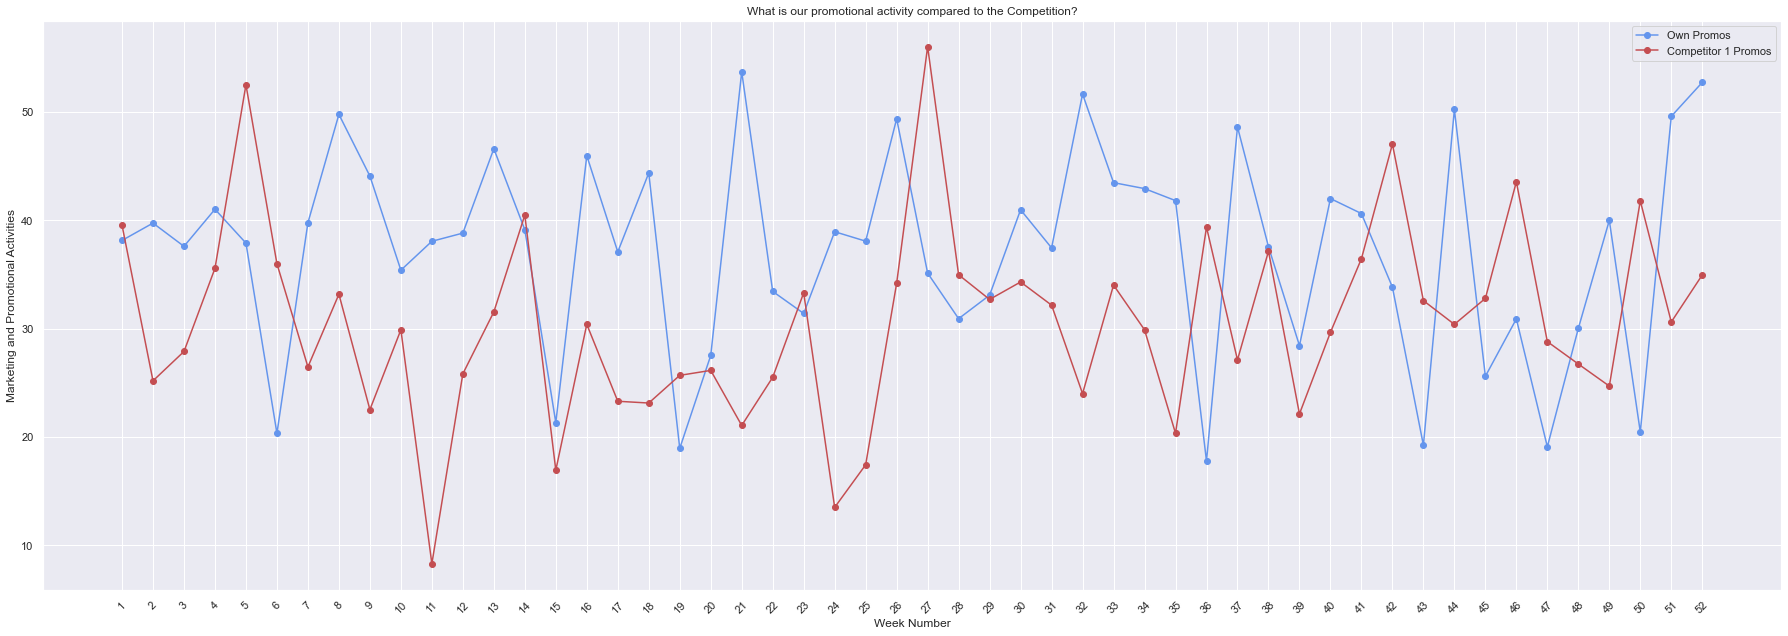

In [101]:
plt.plot(data['week_number'].tail(52),data['x2'].tail(52), marker='o', linestyle='-', color='cornflowerblue', label='Own Promos')
plt.plot(data['week_number'].tail(52),data['x5'].tail(52), marker='o', linestyle='-', color='r', label='Competitor 1 Promos')
plt.title('What is our promotional activity compared to the Competition?')
plt.xlabel('Week Number')
plt.ylabel('Marketing and Promotional Activities')
plt.xticks(range(1,53), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

We generally have higher promotional activity than our competitors.

What is our market presence compared to the competition?


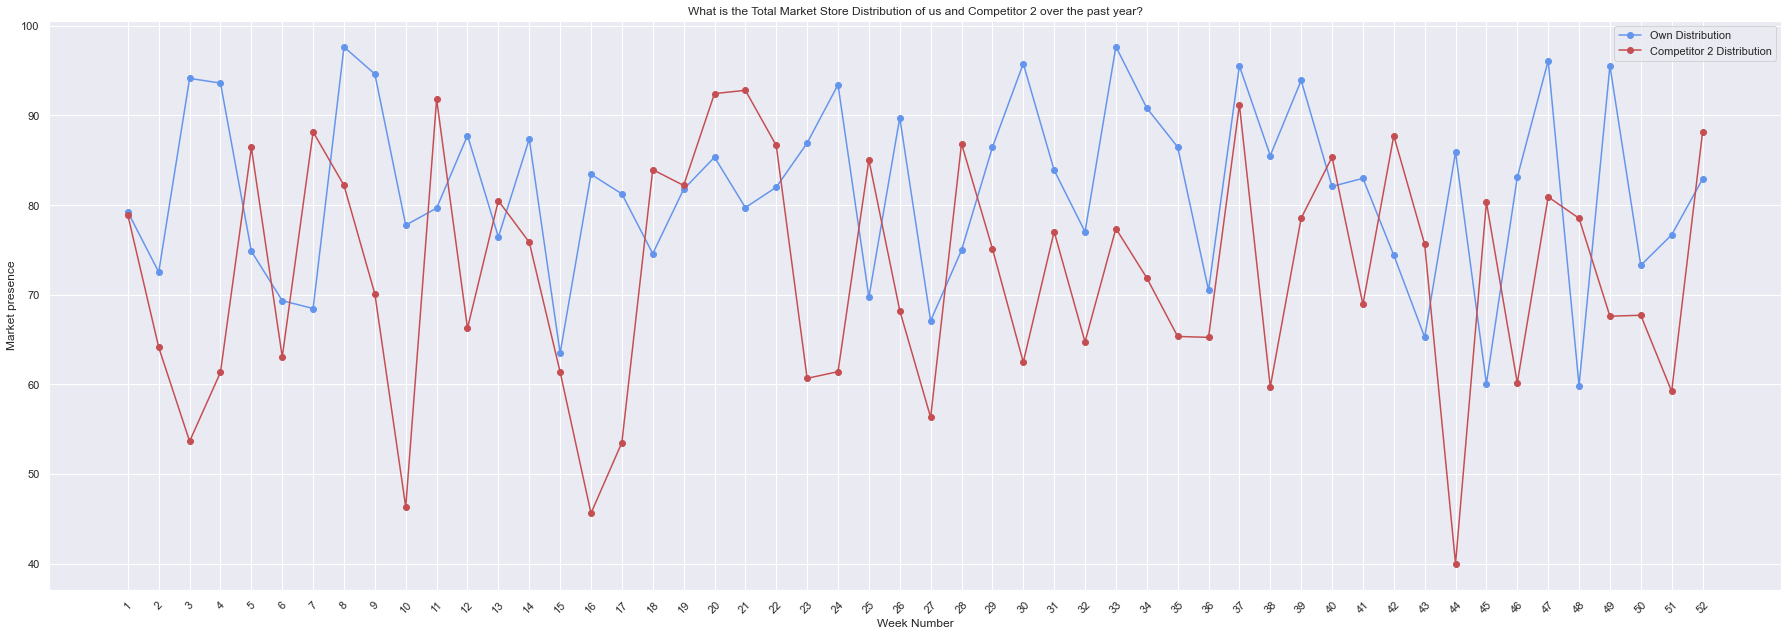

In [102]:
plt.plot(data['week_number'].tail(52),data['x3'].tail(52), marker='o', linestyle='-', color='cornflowerblue', label='Own Distribution')
plt.plot(data['week_number'].tail(52),data['x7'].tail(52), marker='o', linestyle='-', color='r', label='Competitor 2 Distribution')
plt.title('What is the Total Market Store Distribution of us and Competitor 2 over the past year?')
plt.xlabel('Week Number')
plt.ylabel('Market presence')
plt.xticks(range(1,53), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Our own market presence has generally been stronger than Competitor 2.

Lets take a look at how our product price have evolved the past year.

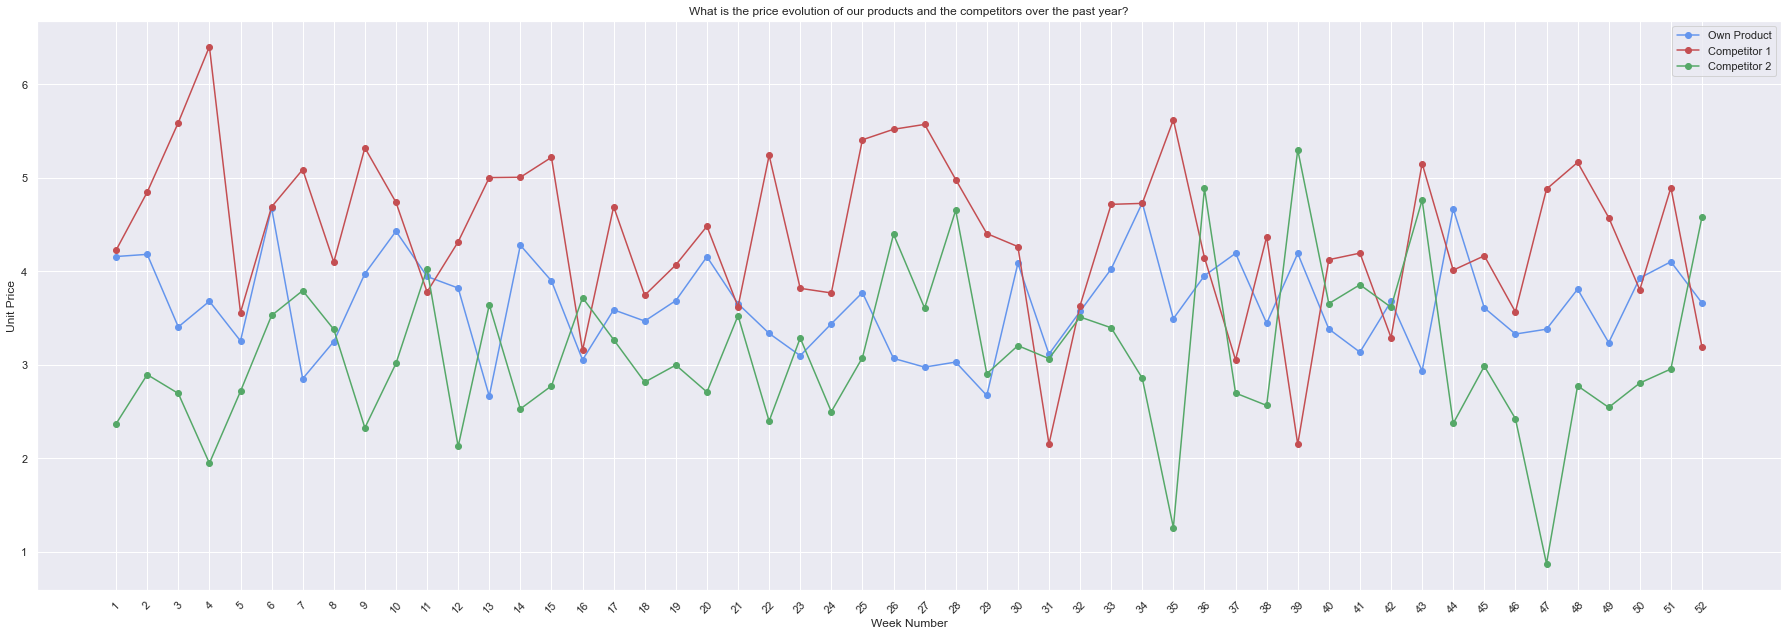

In [103]:
plt.plot(data['week_number'].tail(52),data['x1'].tail(52), marker='o', linestyle='-', color='cornflowerblue', label='Own Product')
plt.plot(data['week_number'].tail(52),data['x4'].tail(52), marker='o', linestyle='-', color='r', label='Competitor 1')
plt.plot(data['week_number'].tail(52),data['x6'].tail(52), marker='o', linestyle='-', color='g', label='Competitor 2')
plt.title('What is the price evolution of our products and the competitors over the past year?')
plt.xlabel('Week Number')
plt.ylabel('Unit Price')
plt.xticks(range(1,53), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Competitor 1 has much higher product price from our own as well as from competitor 2. However Competitor 2 generally has lower price than us , which might mean customers might turn to their product instead of ours.

We group the data by month and see if there is any apparent seasonal effect.

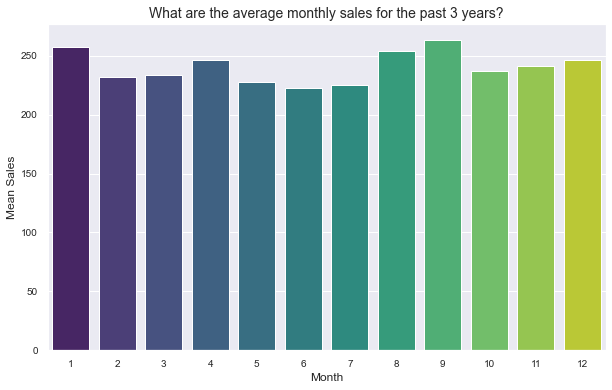

In [104]:
mean_sales_by_month = data.groupby('month')['y'].mean().reset_index()

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_sales_by_month, x='month', y='y', palette='viridis')

# Add labels and title
plt.xlabel('Month', fontsize=12)
plt.ylabel('Mean Sales', fontsize=12)
plt.title('What are the average monthly sales for the past 3 years?', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

There appears to be weak seasonality in the data. There is a slight peak at months 8,9 and 1 but the difference from the other random months seems small. We will investigate further.

The line plots of the past 2 years also does not show similar patterns. This is another indication against seasonality.

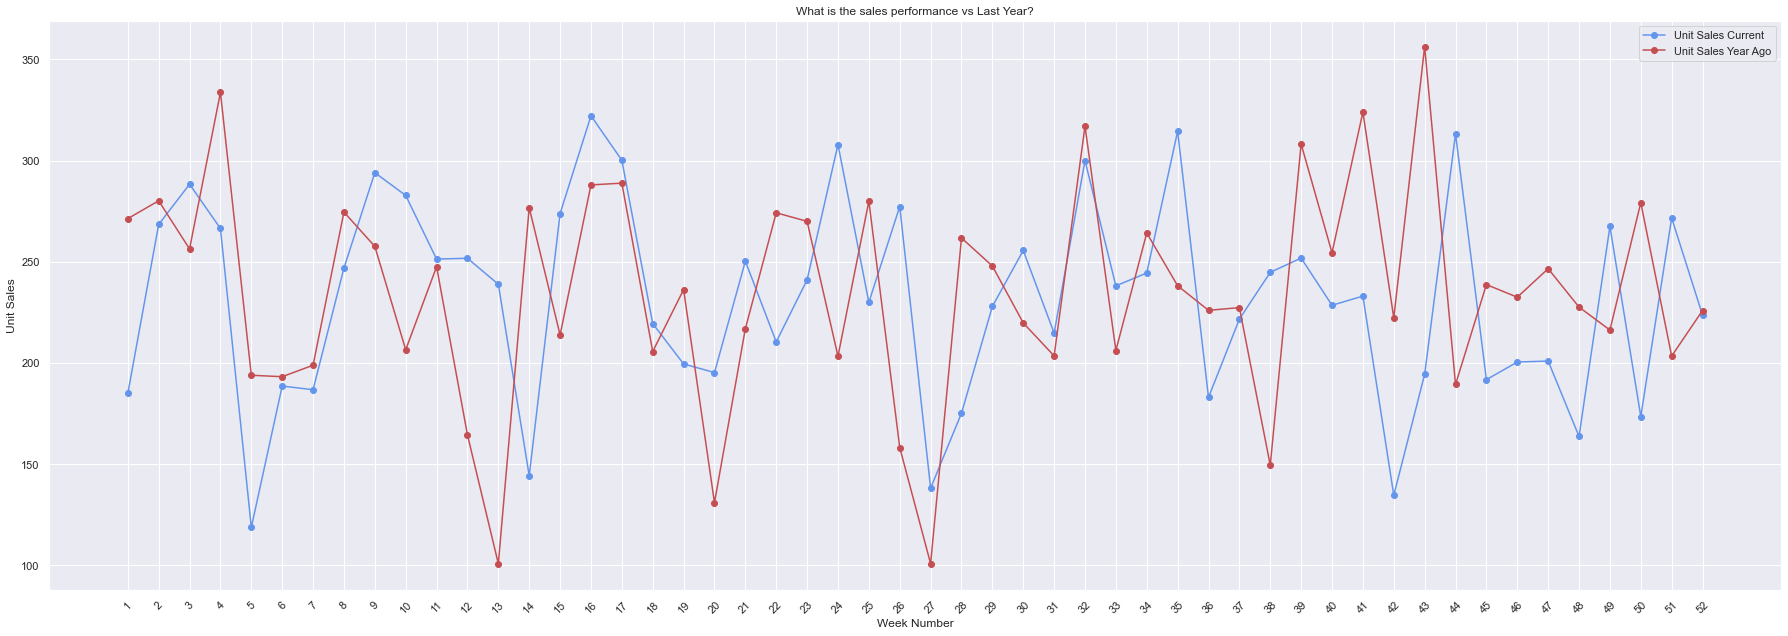

In [105]:
plt.plot(data['week_number'].tail(52),data['y'].tail(52), marker='o', linestyle='-', color='cornflowerblue', label='Unit Sales Current')
plt.plot(data['week_number'].tail(52),data.loc[np.where(data['year']==2)]['y'], marker='o', linestyle='-', color='r', label='Unit Sales Year Ago')
plt.title('What is the sales performance vs Last Year?')
plt.xlabel('Week Number')
plt.ylabel('Unit Sales')
plt.xticks(range(1,53), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

We start by plotting the Auto Correlation and Partial Autocorrelation functions for each variable of the dataset in order to investigate the seasonality effect on our data.

In [106]:
## Function to plot Pacf and Acf ##

def plot_acf_pacf(feature):
    f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
    plot_acf(data['x7'],lags=52, ax=ax[0],title = 'Autocorrelation for ' + str(feature))
    plot_pacf(data['x7'],lags=52, ax=ax[1], method='ols' , title='Partial Autocorrelation for ' + str(feature))

    plt.tight_layout()
    plt.show()

In [107]:
columns_to_plot=data.copy(deep=True)

In [108]:
columns_to_plot.drop(['week','week_number','month'],axis=1,inplace=True)

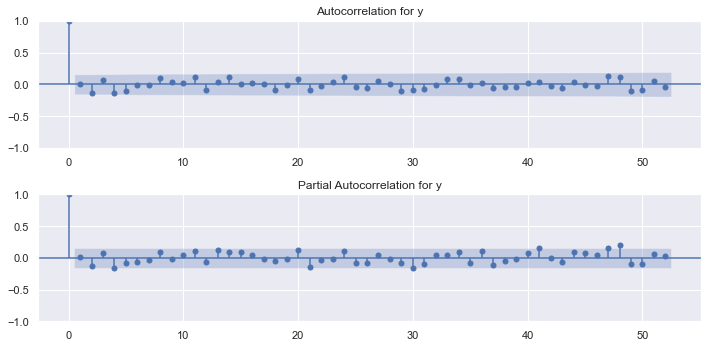

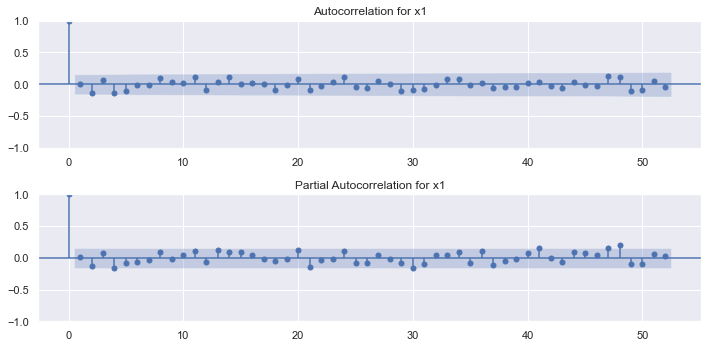

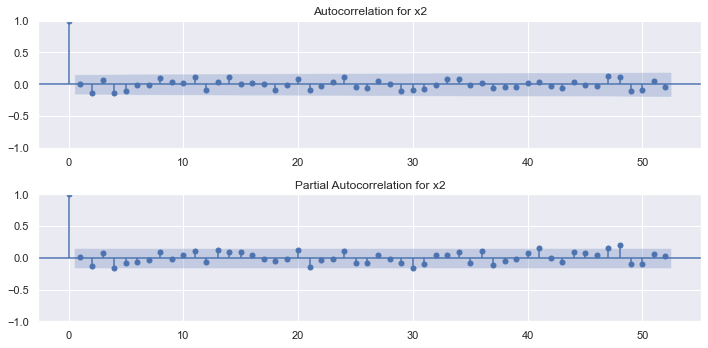

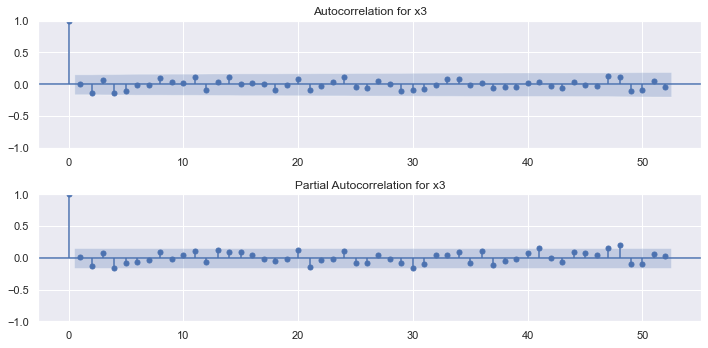

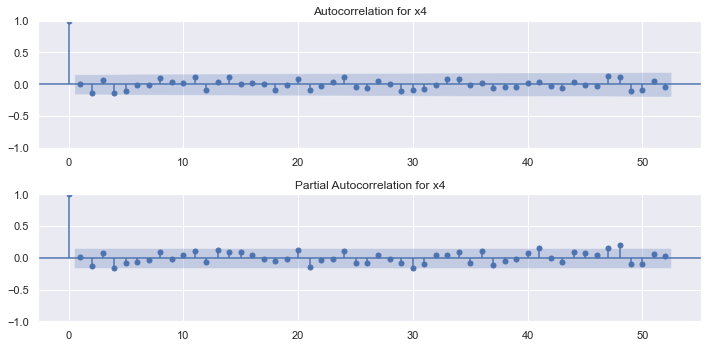

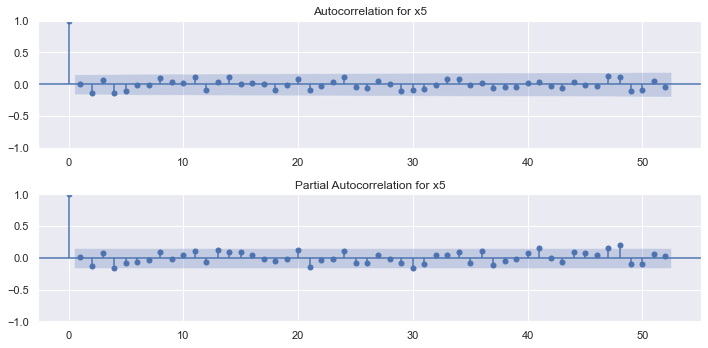

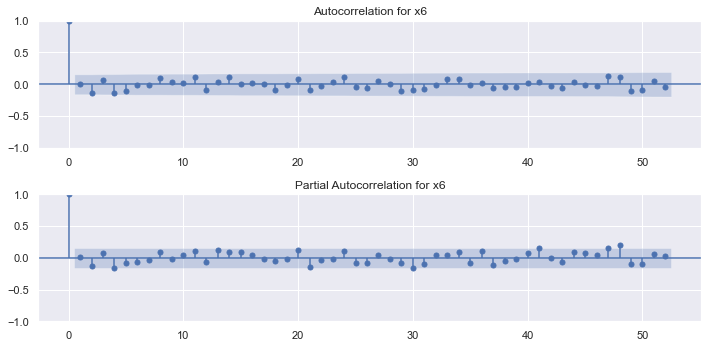

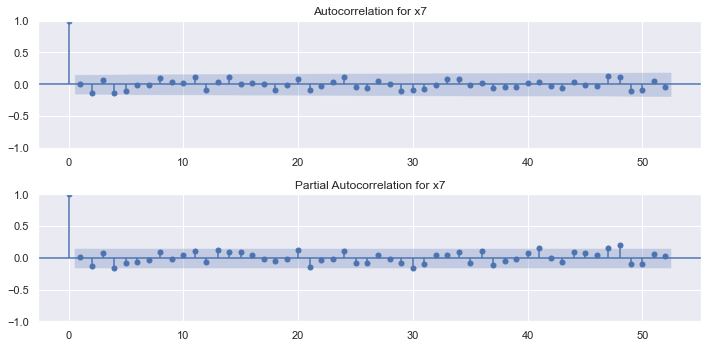

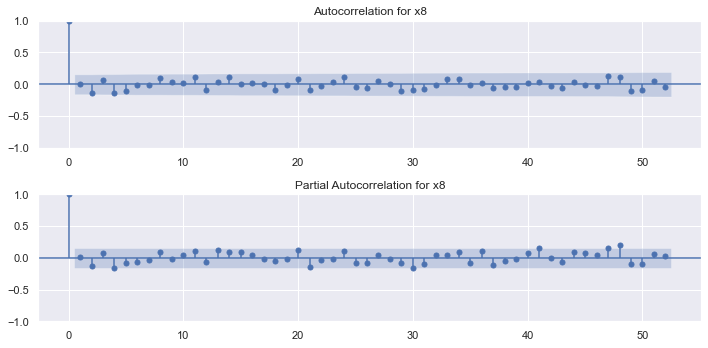

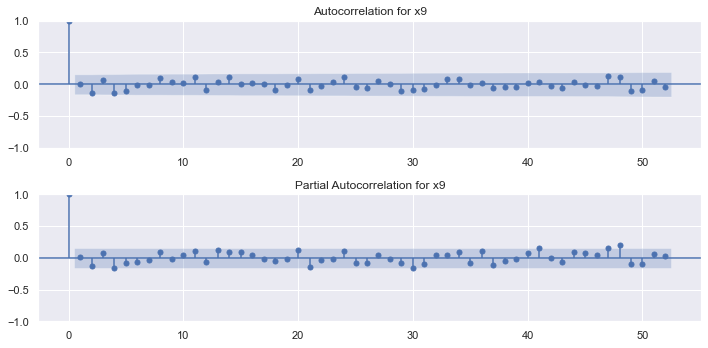

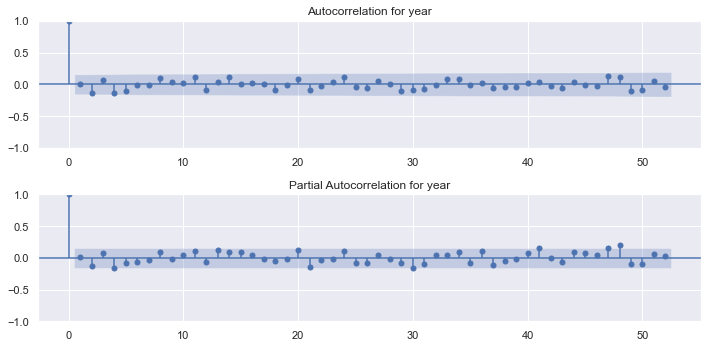

In [109]:
for column in columns_to_plot.columns:
    plot_acf_pacf(column)

No significant patterns are spotted in any of the variables. In order to be certain we will investigate further by decomposing the own sales variable.

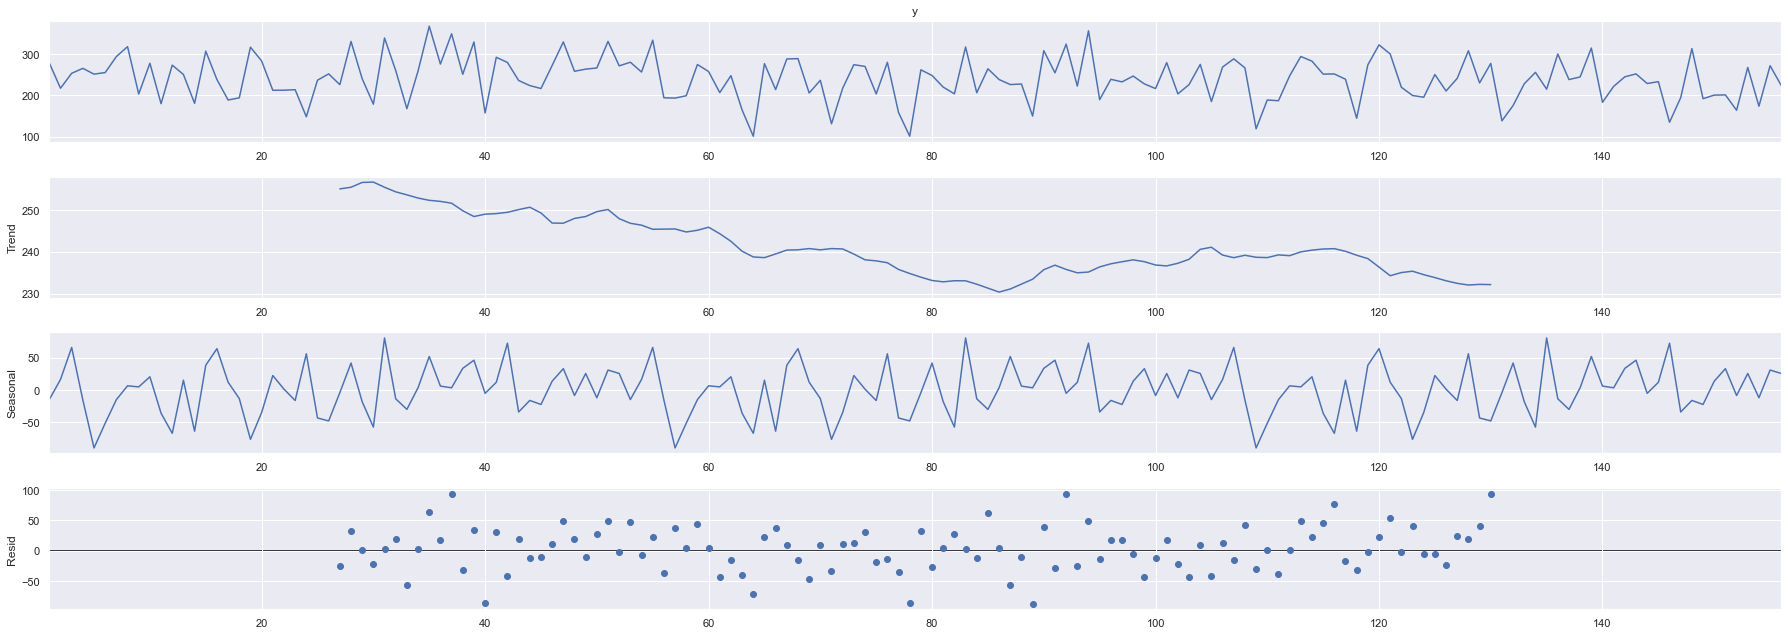

In [110]:
decomposition = seasonal_decompose(data['y'], model='additive', period=52)  # Assuming yearly seasonality which is 52 weeks(periods)
decomposition.plot()
plt.show()

The seasonal part of the decomposition plot shows no clear pattern so this could be an indication of weak to no seasonality.In order to be certain we will test further.

Generally we have no strong indication of seasonality, so as a last step we will perform a Kruskal-Wallis test to see if there is a significant impact on the medians of each week.
* Note : * We use Kruskal–Wallis because we have ordinal categorical data (month)

Hypothesis: 
* H0: The medians of each group are the same
* H1: At least one of the groups has a different median

In [111]:
grouped_data = [group['y'].values for _, group in data.groupby('month')]

stat, p_value = kruskal(*grouped_data)
print(f"Kruskal-Wallis Test Statistic: {stat}")
print(f"P-value: {p_value}")

Kruskal-Wallis Test Statistic: 8.475352281485804
P-value: 0.6701952173611747


Since the p-value is >0.05 we fail to reject the null hypothesis at a statistical significance level of 5%.
Therefore we assume the sales data does not show significant seasonal patterns

The sales data does not show significant seasonality and because the ACF and PACF functions of the independent variables do not show signicant trends/patterns we will assume the data is random and not seasonal.

In [112]:
data.drop(['month','week','week_number','year'],axis=1 , inplace =True) #remove the month and week variable since we wont be needing them.

**TASK 2: HYPOTHESIS TESTING**

We will test for linear correlations between the response variable and the independent variables using Pearson correlation test.

In [113]:
def pearson_test(test_variable):
    response = data['y']
    independent = data[test_variable]

    correlation, p_value = pearsonr(response, independent)

    print(f"Pearson Correlation Coefficient: {correlation}")
    print(f"P-Value: {p_value}")

1 - Hypothesis :
* H0 : Own product price does not have an effect on sales
* H1 : Own product price has an effect on sales

In [114]:
pearson_test('x1')

Pearson Correlation Coefficient: 0.04553374050251558
P-Value: 0.5724579842382775


* Since p-value is >0.5 ,we fail to reject the null hypothesis in favor of the alternative H1 in a statistical significance level of 5%. 

2- Hypothesis:
* H0 : Own promo activities do not have an effect on own sales
* H1 : Own promo activities have an effect on own sales

In [115]:
pearson_test('x2')

Pearson Correlation Coefficient: 0.4520860468437725
P-Value: 3.1352813368944283e-09


* Since p-value is <0.5 ,we reject the null hypothesis in favor of the alternative H1 in a statistical significance level of 5%.
* Own promo activities have a positive effect on sales and they have a strong positive linear correlation. 
* When own promo activities increase sales tend to increase as well

3 - Hypothesis:
* H0 : Own distribution does not have an effect on own sales
* H1 : Own distribution has an effect on own sales

In [116]:
pearson_test('x3')

Pearson Correlation Coefficient: 0.2852823326168884
P-Value: 0.0003063976318165426


* Since p-value is <0.5 ,we reject the null hypothesis in favor of the alternative H1 in a statistical significance level of 5%.
* Own distribution has a positive effect on sales and they have a weak positive linear correlation. 

4- Hypothesis:
* H0 : Competitor 1 product price does not have an effect on own sales
* H1 : Competitor 1 product price has an effect on own sales

In [117]:
pearson_test('x4')

Pearson Correlation Coefficient: 0.04377733582640278
P-Value: 0.5873766414101774


* Since p-value is >0.5 ,we fail to reject the null hypothesis in favor of the alternative H1 in a statistical significance level of 5%. 
* The product price of competitor 1 does not have a significant correlation on own sales

5- Hypothesis:
* H0 : Competitor 1 promo activity does not have an effect on own sales
* H1 : Competitor 1 promo activity has an effect on own sales

In [118]:
pearson_test('x5')

Pearson Correlation Coefficient: -0.6729353529787315
P-Value: 6.469669868377391e-22


* Since p-value is <0.5 ,we reject the null hypothesis in favor of the alternative H1 in a statistical significance level of 5%.
* Promo activity of competitor 1 has a strong negative correlation on our own sales.
* When competitor 1 increases the promo activity our sales tend to decrease.

6- Hypothesis:
* H0 : Competitor 2 product price does not have an effect on own sales
* H1 : Competitor 2 product price activity has an effect on own sales

In [119]:
pearson_test('x6')

Pearson Correlation Coefficient: 0.10651465500367223
P-Value: 0.18569031872581318


* Since p-value is >0.5 ,we fail to reject the null hypothesis in favor of the alternative H1 in a statistical significance level of 5%. 
* The product price of competitor 2 does not have a significant effect on own sales

7 - Hypothesis:
* H0 : Competitor 2 product appearence does not have an effect on own sales
* H1 : Competitor 2 product appearence has an effect on own sales

In [120]:
pearson_test('x7')

Pearson Correlation Coefficient: -0.5995934693688142
P-Value: 1.3369651109395835e-16


* Since p-value is <0.5 ,we reject the null hypothesis in favor of the alternative H1 in a statistical significance level of 5%.
* Product appearence of competitor 2 has a strong negative correlation (impact) on our own sales.

**TASK 3 REGRESSION ANALYSIS**

In [121]:
y=data['y']
x=data.drop('y',axis=1)
x=sm.add_constant(x)
model =sm.OLS(y,x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     253.9
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           1.75e-84
Time:                        23:10:30   Log-Likelihood:                -618.98
No. Observations:                 156   AIC:                             1258.
Df Residuals:                     146   BIC:                             1288.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        337.9282     16.994     19.886      0.000     304.343     371.513
x1            -3.2946      2.070     -1.592      0.114      -7.386       0.797
x2             2.1472      0.113     18.986      0.000       1.924       2.371
x3             0.7428      0.114      6.521      0.000       0.518       0.968
x4            -0.1100      1.389     -0.079      0.937      -2.855       2.635
x5            -3.1279      0.113    -27.736      0.000      -3.351      -2.905
x6             3.4706      1.393      2.491      0.014       0.717       6.224
x7            -2.0623      0.082    -25.267      0.000      -2.224      -1.901
x8             0.0162      0.041      0.393      0.695      -0.065       0.097
x9             0.0019      0.050      0.037      0.970      -0.098       0.102
==============================================================================
Omnibus:                       20.886   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.419
Skew:                          -0.633   Prob(JB):                     4.54e-09
Kurtosis:                       5.076   Cond. No.                     1.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We will iteratively drop the statistically insignificant variables with p-value > 0.05 

Drop x1

In [122]:
x_1=data.drop(['y','x1'],axis=1)
x_1=sm.add_constant(x_1)
model =sm.OLS(y,x_1)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     282.4
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           3.52e-85
Time:                        23:10:31   Log-Likelihood:                -620.33
No. Observations:                 156   AIC:                             1259.
Df Residuals:                     147   BIC:                             1286.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        324.6353     14.876     21.822      0.000     295.236     354.034
x2             2.1487      0.114     18.900      0.000       1.924       2.373
x3             0.7308      0.114      6.396      0.000       0.505       0.957
x4            -0.0673      1.396     -0.048      0.962      -2.826       2.691
x5            -3.1263      0.113    -27.579      0.000      -3.350      -2.902
x6             3.5969      1.398      2.573      0.011       0.834       6.360
x7            -2.0477      0.082    -25.117      0.000      -2.209      -1.887
x8             0.0198      0.041      0.480      0.632      -0.062       0.101
x9             0.0026      0.051      0.051      0.960      -0.098       0.103
==============================================================================
Omnibus:                       20.070   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.881
Skew:                          -0.597   Prob(JB):                     5.95e-09
Kurtosis:                       5.098   Cond. No.                     1.66e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Drop x4

In [123]:
x_2=data.drop(['y','x1','x4'],axis=1)
x_2=sm.add_constant(x_2)
model =sm.OLS(y,x_2)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     324.9
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           1.88e-86
Time:                        23:10:31   Log-Likelihood:                -620.33
No. Observations:                 156   AIC:                             1257.
Df Residuals:                     148   BIC:                             1281.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        324.2890     12.986     24.973      0.000     298.628     349.950
x2             2.1493      0.112     19.121      0.000       1.927       2.371
x3             0.7303      0.113      6.443      0.000       0.506       0.954
x5            -3.1260      0.113    -27.704      0.000      -3.349      -2.903
x6             3.6080      1.374      2.625      0.010       0.892       6.324
x7            -2.0472      0.081    -25.388      0.000      -2.207      -1.888
x8             0.0198      0.041      0.481      0.631      -0.062       0.101
x9             0.0022      0.050      0.044      0.965      -0.096       0.101
==============================================================================
Omnibus:                       20.260   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.448
Skew:                          -0.601   Prob(JB):                     4.48e-09
Kurtosis:                       5.114   Cond. No.                     1.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Drop x8 and x9

In [124]:
x_3=data.drop(['y','x1','x4','x8','x9'],axis=1)
x_3=sm.add_constant(x_3)
model =sm.OLS(y,x_3)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     460.2
Date:                Thu, 23 Jan 2025   Prob (F-statistic):           4.59e-89
Time:                        23:10:31   Log-Likelihood:                -620.45
No. Observations:                 156   AIC:                             1253.
Df Residuals:                     150   BIC:                             1271.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        325.6592     12.597     25.853      0.000     300.770     350.549
x2             2.1414      0.110     19.419      0.000       1.924       2.359
x3             0.7259      0.112      6.492      0.000       0.505       0.947
x5            -3.1324      0.109    -28.641      0.000      -3.349      -2.916
x6             3.6552      1.361      2.685      0.008       0.966       6.345
x7            -2.0551      0.078    -26.194      0.000      -2.210      -1.900
==============================================================================
Omnibus:                       19.844   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.028
Skew:                          -0.584   Prob(JB):                     5.52e-09
Kurtosis:                       5.118   Cond. No.                     1.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The F statistic of the final model's p-value is almost zero which means that we reject the null hypothesis that all coefficients are zero at the same time.

* Overall we have removed x1,x4,x8 and x9. 
* The overall model performance has improved slightly from Adjusted R squared 0.936 to 0.937. This means that the final model can interpret about 93.7 of variance.

* The variables we have removed showed no significant statistical relationship with the response variable. This was expected as x8 and x9 had very little data as we observed from the start. Also x1 and x4 had very weak linear correlation with the target variable and as expected they were weak predictors.
* The analysis for the remaining statisticaly important variables is as follows:
<br>
<br>

1.  x2 has a coefficient of 2.14. This means that considering all other variables are stable , that if our own promotional activities are increased by 1 unit , our own product sales are increased by 2.14 units. This means that our own promos have a very strong positive impact on our sales.
<br> 

2.  x3 has a coefficent of 0.72. This means that considering all other variables are stable, if the distribution of our own product in stores is increased by 1% , then our sales are increased by 0.71 units. This means that increased product presense in stores has a positive impact on our sales.
<br>

3. Lastly the intercept of 325 means that if all other variables are zero (such as our own product price is zero or that if our own products appearence in total market stores is zero) we are excpected to sell 325 units of our own product. This doesnt make much sense but we will leave the constant in our model because if we remove it we force the regression line to pass through point O(0,0) which will introduce a lot of bias in our data.

**TASK 4 COMPETITOR ANALYSIS**


Based on our model results above : 
1. x5 has a coefficent of -3.13. This means that considering all other variables are stable, if competitor 1 increases his promotional activity by 1 unit , our own sales are decreased by 3.13 units. This means that increased competitor promotional activity has a strong negative impact on our own sales.
<br>

2. x6 has a coefficient of 3.65. This means that considering all other variables are stable, if competitor 2 increases his products price , then our own product sales are increased by 3.6 units. This means that increased competitor products price has a positive impact on our own sales.
<br>

3. Lastly x7 has a coefficient of -2.05. This means that considering all other variables are stable, if competitor 2 increases his product appearence in stores by 1 % , our own sales are decreased by 2.05 units. This means that the presense of competitors 2 product has a negative effect on our own product sales.

**Overall we can conclude that our own product sales are influenced by our own and the competitions promotional activity and market presence , and not influenced by our own product price and from competitor 1 products price.**

Lastly we check that the assumptions of the linear regression hold. Namely :
* Independence of errors (Durbin Watson test)
* Homoscedasticity (Breusch-Pagan Test)
* Linearity (Residual vs Fitted Value Plot)
* Normality of residuals (QQ plot)


**Durbin Watson test**

* H0 = first order autocorrelation does Not exist.
* H1 = first order correlation exists.
<br>

* Since our value is greater than 2 we fail to reject the null hypothesis. The is no significant autocorrelation in the residuals.

In [125]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(results.resid)
print(f'Durbin-Watson Statistic: {dw_stat}')

Durbin-Watson Statistic: 2.174939753493887


**Breusch-Pagan Test**
<br>

* H0: Homoscedasticity is present
* H1: Heteroscedasticity is present 

In [126]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(results.resid, results.model.exog)
print(f'Breusch-Pagan Test Statistic: {bp_test[0]}, P-value: {bp_test[1]}')

Breusch-Pagan Test Statistic: 9.230748157840797, P-value: 0.1002068555153449


Since the p-value is greatet than 0.5 we fail to reject the null hypothesis. We conclude that homoscedasticity is present.

**Linearity**

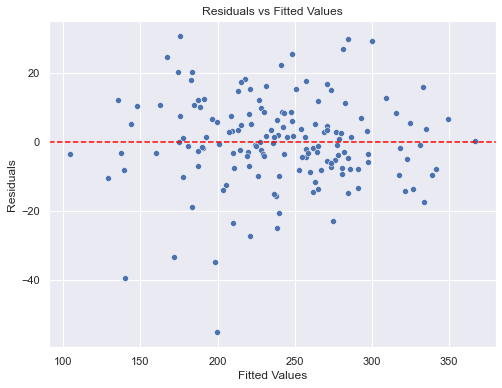

In [127]:
residuals = results.resid
fitted_values = results.fittedvalues

plt.figure(figsize=(8, 6))
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

The residuals are placed randomly around the 0 line. This suggests that the assumption that the relationship is linear is reasonable.

**Normality of residuals**

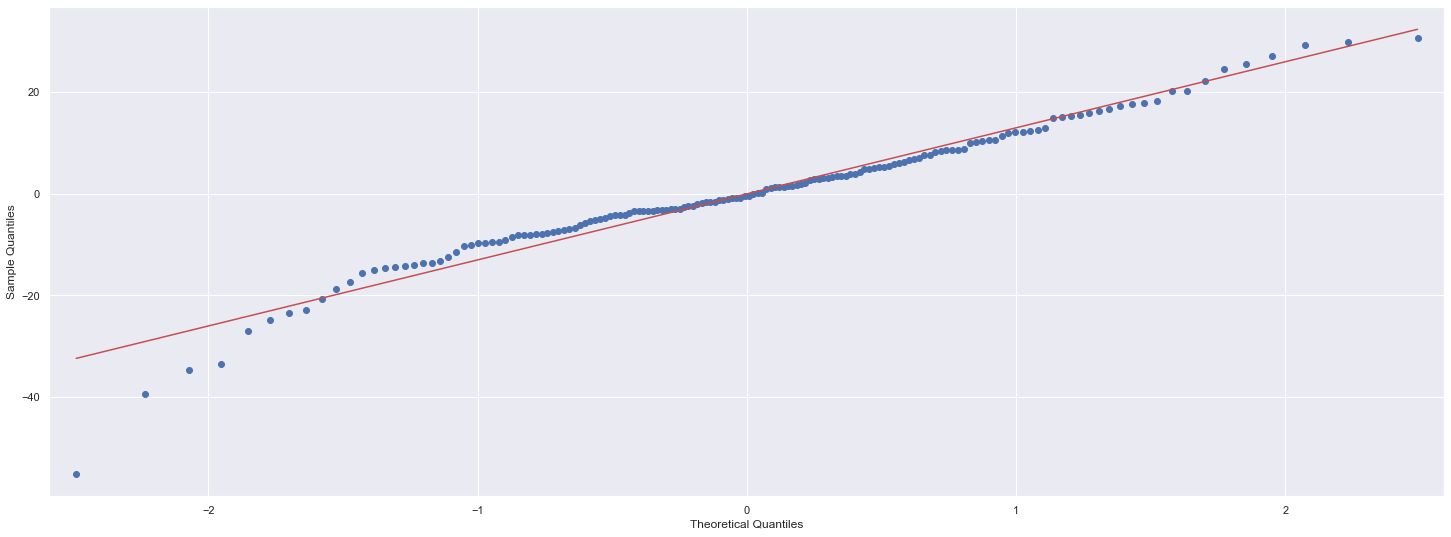

In [128]:
sm.qqplot(results.resid, line='r')
plt.show()

The deviations from the line are minimal which indicates normality or residuals.

We conclude that the basic assumptions of linear regression hold for our model.

**TASK 5 MARKETING STRATEGY**

Its important to note that from the variables that proved statistically significant , we do not have control over our competitors variables, only our own. Therefore we will adjust our strategy based on the variables we can control.
Based on our analysis and the variables that proved to be statistically significant to our model the propositions are as follows:
* Proposal 1: Prioritize promotional activity on under-represented markets to increase market share.
* Proposal 2: Match competitor’s 1 promotional activities with our own to mitigate their negative impact on our sales.
* Proposal 3: Increase promotional activity when competitor 1 increases their product price , to attract price-sensitive customers and gain market share.
* Proposal 4: Increase our promotions on markets that competitor 2 is dominant, to gain market share. 